In [1]:
import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os 
import cv2

abnormal_dir = r'E:\Saaswath\brain tumor\source code\dataset\abnormal\1'
normal = r'E:\Saaswath\brain tumor\source code\dataset\normal\1'
file_name = [i for i in os.listdir(abnormal_dir)]

for i in file_name[:2]:
    image_read = cv2.imread(abnormal_dir+'/'+i)
    resize = cv2.resize(image_read,(128,128))
    cvt_color = cv2.cvtColor(resize,cv2.COLOR_RGB2GRAY)
    filter_img = cv2.GaussianBlur(cvt_color,(21,21),0)
    th3 = cv2.threshold(filter_img,127,255,cv2.THRESH_TOZERO_INV)
    show = cv2.imshow("image",th3[1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
file_name = [i for i in os.listdir(normal)]

for i in file_name[:2]:
    image_read = cv2.imread(normal+'/'+i)
    resize = cv2.resize(image_read,(224,224))
    cvt_color = cv2.cvtColor(resize,cv2.COLOR_RGB2GRAY)
    filter_img = cv2.GaussianBlur(cvt_color,(21,21),0)
    th3 = cv2.threshold(filter_img,127,255,cv2.THRESH_TOZERO_INV)
    show = cv2.imshow("image",th3[1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
dataset = ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,rotation_range=0.3,validation_split=0.3)

train_df = dataset.flow_from_directory(directory=r'E:\Saaswath\brain tumor\source code\dataset',target_size=(128,128),subset="training",batch_size=32,color_mode='rgb')

validation_df = dataset.flow_from_directory(directory=r'E:\Saaswath\brain tumor\source code\dataset',target_size=(128,128),subset="validation",batch_size=32,color_mode='rgb')

trainclasses =train_df.class_indices
n_classes = len(train_df.class_indices)

resultmap={}
for faceValue,faceName in zip(trainclasses.values(),trainclasses.keys()):
  resultmap[faceValue]=faceName

import pickle
with open("resultmap.pkl",'wb') as file:
  pickle.dump(resultmap,file)


Found 140 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [5]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [7]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [8]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [12]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [9]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [10]:
 # inputs
def build_unet_model():

  inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
  f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
  f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
  f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
  f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
  bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
  u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
  u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
  u9 = upsample_block(u8, f1, 64)
  
  u10 = layers.Flatten()(u9)
   # outputs
  outputs = layers.Dense(2,activation='softmax')(u10)

   # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [13]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics="accuracy")

In [15]:
x_train , y_train = next(train_df)

In [16]:
model_history = unet_model.fit(train_df,
                              epochs=5,
                              validation_data = validation_df)

Epoch 1/5
5/5 [==============================] - 188s 43s/step - loss: 521.6055 - accuracy: 0.5643 - val_loss: 0.3957 - val_accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 171s 40s/step - loss: 0.5479 - accuracy: 0.8429 - val_loss: 0.1168 - val_accuracy: 0.9667
Epoch 3/5
5/5 [==============================] - 170s 39s/step - loss: 4.0091 - accuracy: 0.6357 - val_loss: 0.5822 - val_accuracy: 0.7333
Epoch 4/5
5/5 [==============================] - 181s 36s/step - loss: 0.8638 - accuracy: 0.8000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/5
5/5 [==============================] - 182s 34s/step - loss: 0.0180 - accuracy: 0.9929 - val_loss: 5.6105e-05 - val_accuracy: 1.0000


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np 
for i,layer in enumerate(unet_model.layers):
    print(i,layer.name)

    model = Model(inputs=unet_model.input,outputs=unet_model.get_layer(layer.name).output,)

    img_path = r'E:\Saaswath\brain tumor\source code\i\IM-0597-0001.jpg'
    img = image.load_img(img_path,target_size=(128,128))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    pred = model.predict(x)
    print(pred)


0 input_1
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]
 [11. 11. 11.]
 [14. 14. 14.]
 [ 6.  6.  6.]
 [ 4.  4.  4.]
 [ 5.  5.  5.]
 [ 1.  1.  1.]
 [ 8.  8.  8.]
 [13. 13. 13.]
 [12. 12. 12.]
 [13. 13. 13.]
 [11. 11. 11.]
 [12. 12. 12.]
 [11. 11. 11.]
 [11. 11. 11.]
 [10. 10. 10.]
 [12. 12. 12.]
 [13. 13. 13.]
 [11. 11. 11.]
 [13. 13. 13.]
 [ 8.  8.  8.]
 [10. 10. 10.]


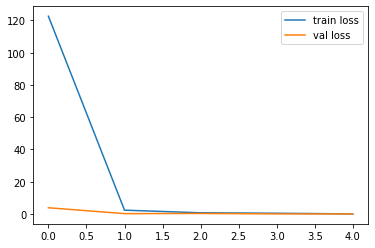

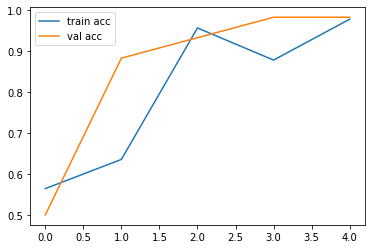

<Figure size 432x288 with 0 Axes>

In [15]:
unet_model.save("unet_model.h5")
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [2]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import cv2
import numpy as np 
import pickle
model = load_model('./unet_model.h5')
img = cv2.imread(r"E:\Saaswath\brain tumor\source code\dataset\Normal\1\24 resized.png")
ch_size = cv2.resize(img,(128,128))
image = img_to_array(ch_size)
image = np.expand_dims(image,axis=0)
pred = model.predict(image)
result = pickle.load(open("resultmap.pkl","rb"))
classes  = result[np.argmax(pred)]
output =f'{classes} :%1.2f'%(pred[0,0])
cv2.putText(ch_size, output, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,255), 2)
cv2.imshow("image",ch_size)
cv2.waitKey(0) 
cv2.destroyAllWindows() 

ModuleNotFoundError: No module named 'keras'